# Implementing "All you need is ATTENTION"
## -Apply to Sentiment Analysis
<br/>
thanks to https://paul-hyun.github.io/transformer-01/

## Imports

In [71]:
import os
import json
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm, tqdm_notebook, trange
import sentencepiece as spm
import wget

import torch
import torch.nn as nn
import torch.nn.functional as F

## Index
- [Step 1 - Preparing Word dataset](#step-1---preparing-word-dataset)
  * [Step 1-1 : making corpus from WIKI](#step-1-1---making-corpus-from-wiki)
  * [Step 1-2 : making Vocab using Google Sentencepiece](#step-1-2---making-vocab-using-google-sentencepiece)
  * [Step 1-3 : Preprocessing Naver Movie Review Sentiment Data](#step-1-3---preprocessing-naver-movie-review-sentiment-data)
    + [Download](#download)
    + [Load Vocab](#load-vocab)
    + [Preprocessing data](#preprocessing-data)
- [Step 2 - Prepare Modules for Transformer](#step-2---prepare-modules-for-transformer)
  * [Step 2-1 : Embedding](#step-2-1---embedding)
    + [Input Embedding](#input-embedding)
    + [Position Embedding](#position-embedding)
  * [Step 2-2 : Scaled Dot Product Attention](#step-2-2---scaled-dot-product-attention)
  * [Step 2-3 : Multi-Head Attention](#step-2-3---multi-head-attention)
  * [Step 2-4 : Masked Multi-Head Attention](#step-2-4---masked-multi-head-attention)
  * [Step 2-5 : FeedForward](#step-2-5---feedforward)
    + [Step 2 Summary](#step-2-summary)
- [Step 3 - Build a Transformer](#step-3---build-a-transformer)
  * [Step 3-1 : Config](#step-3-1---config)
  * [Step 3-2 : Redefine Classes using config](#step-3-2---redefine-classes-using-config)
  * [Step 3-3 : Encoder](#step-3-3---encoder)
    + [Encoder layer](#encoder-layer)
    + [Encoder](#encoder)
  * [Step 3-4 : Decoder](#step-3-4---decoder)
    + [Decoder layer](#decoder-layer)
    + [Decoder](#decoder)
  * [Step 3-5 : Transformer](#step-3-5---transformer)
- [Step 4 - Apply Transformer (Sentiment Analysis)](#step-4---apply-transformer--sentiment-analysis-)
  * [Step 4-1 : Model](#step-4-1---model)
  * [Step 4-2 : DataSet](#step-4-2---dataset)
    + [DataSet](#dataset)
    + [Batch unit processing](#batch-unit-processing)
    + [DataLoader](#dataloader)
  * [Step 4-3 : Evaluate](#step-4-3---evaluate)
  * [Step 4-4 : Train](#step-4-4---train)
- [Result](#result)

# Step 1 - Preparing Word dataset

## Step 1-1 : making corpus from WIKI

I used "wikiextractor" which is already implemented in github.

In [ ]:
!git clone https://github.com/paul-hyun/web-crawler.git
!cd web-crawler
!pip install tqdm
!pip install pandas
!pip install bs4
!pip install wget
!pip install pymongo
!python kowiki.py

I entered the codes above in my mac console.  
This code will prepare us a csv file with includes tons of corpus.

In [22]:
import pandas as pd
import sys, csv

csv.field_size_limit(sys.maxsize) # csv file is big, so you need to enlarge it
in_file = "kowiki/kowiki_20211218.csv"
out_file = "kowiki/kowiki.txt"
SEPARATOR = u"\u241D"

df = pd.read_csv(in_file, sep=SEPARATOR, engine="python")

with open(out_file, "w") as f:
    for index, row in df.iterrows():
        f.write(row["text"]) # only get test because title is redundant
        f.write("\n\n\n\n") # delim

## Step 1-2 : making Vocab using Google Sentencepiece

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm

corpus = "kowiki/kowiki.txt"
prefix = "kowiki"
vocab_size = 8000
spm.SentencePieceTrainer.train(
    f"--input={corpus} --model_prefix={prefix} --vocab_size={vocab_size + 7}" + 
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # sentence length maximum
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # User defined symbols

In [26]:
# minitest using Vocab
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

lines = [
  "겨울이 되어서 날씨가 무척 추워요.",
  "이번 성탄절은 화이트 크리스마스가 될까요?",
  "겨울에 감기 조심하시고 행복한 연말 되세요."
]

for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    print(line)
    print(pieces)
    print(ids)
    print()

겨울이 되어서 날씨가 무척 추워요.
['▁겨울', '이', '▁되어', '서', '▁날', '씨', '가', '▁무', '척', '▁추', '워', '요', '.']
[3211, 3536, 635, 3550, 698, 3976, 3547, 107, 4146, 197, 3904, 3708, 3538]

이번 성탄절은 화이트 크리스마스가 될까요?
['▁이번', '▁성', '탄', '절', '은', '▁화', '이트', '▁크리스', '마', '스가', '▁될', '까', '요', '?']
[2912, 88, 3917, 3872, 3552, 269, 662, 1908, 3614, 758, 1432, 3746, 3708, 4210]

겨울에 감기 조심하시고 행복한 연말 되세요.
['▁겨울', '에', '▁감', '기', '▁조', '심', '하', '시', '고', '▁행', '복', '한', '▁연', '말', '▁되', '세', '요', '.']
[3211, 3539, 201, 3554, 53, 3781, 3544, 3561, 3548, 241, 3822, 3551, 63, 3777, 452, 3632, 3708, 3538]



In [28]:
# vocab loading
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

# input texts
lines = [
  "겨울은 추워요.",
  "감기 조심하세요."
]

# convert text to tensor
inputs = []
for line in lines:
    pieces = vocab.encode_as_pieces(line)
    ids = vocab.encode_as_ids(line)
    inputs.append(torch.tensor(ids))
    print(pieces)

# input lengths are different, so add padding(0) to make max input length
inputs = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
# shape
print(inputs.size())
# value
print(inputs)

['▁겨울', '은', '▁추', '워', '요', '.']
['▁감', '기', '▁조', '심', '하', '세', '요', '.']
torch.Size([2, 8])
tensor([[3211, 3552,  197, 3904, 3708, 3538,    0,    0],
        [ 201, 3554,   53, 3781, 3544, 3632, 3708, 3538]])


## Step 1-3 : Preprocessing Naver Movie Review Sentiment Data

### Download

In [ ]:
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
!wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt

### Load Vocab

In [62]:
# vocab loading
vocab_file = "kowiki.model"
vocab = spm.SentencePieceProcessor()
vocab.load(vocab_file)

True

### Preprocessing data
For performance, tokenize the downloaded data to json.

In [63]:
""" train data 준비 """
def prepare_train(vocab, infile, outfile):
    df = pd.read_csv(infile, sep="\t", engine="python")
    with open(outfile, "w") as f:
        for index, row in df.iterrows():
            document = row["document"]
            if type(document) != str:
                continue
            instance = { "id": row["id"], "doc": vocab.encode_as_pieces(document), "label": row["label"] }
            f.write(json.dumps(instance))
            f.write("\n")

In [66]:
prepare_train(vocab, "ratings_train.txt", "ratings_train.json")
prepare_train(vocab, "ratings_test.txt", "ratings_test.json")

# Step 2 - Prepare Modules for Transformer

## Step 2-1 : Embedding
In Transformer, we use "Input Embedding" and "Position Embedding".

### Input Embedding
Convert input tokens to vector form.  
I guess this process is word embedding.

In [31]:
n_vocab = len(vocab) # vocab count
d_hidn = 128 # hidden size
nn_emb = nn.Embedding(n_vocab, d_hidn) # embedding object

input_embs = nn_emb(inputs) # input embedding
print(input_embs.size())

torch.Size([2, 8, 128])


### Position Embedding
We need to go through position encoding before embedding.  
Position encoding is done by following steps.
- 1. Calculate angle for each position.
- 2. For even indices, get sin value.
- 3. For odd indices, get cosine value.

In [32]:
""" sinusoid position embedding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table

Using the result of position encoding, finish position embedding.
- 1. Create position embedding by passing encoding result.
- 2. Positions will have same size with inputs.
- 3. Find pad(0) values in inputs.
- 4. In positions, pad parts become 0.
- 5. Get embedding value for each position.

In [35]:
pos_encoding = torch.FloatTensor(pos_encoding)
nn_pos = nn.Embedding.from_pretrained(pos_encoding, freeze=True)

positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
pos_mask = inputs.eq(0)

positions.masked_fill_(pos_mask, 0)
pos_embs = nn_pos(positions) # position embedding

print("#######Inputs#######\n",inputs)
print("#######Positions#######\n",positions)
print(pos_embs.size())

#######Inputs#######
 tensor([[3211, 3552,  197, 3904, 3708, 3538,    0,    0],
        [ 201, 3554,   53, 3781, 3544, 3632, 3708, 3538]])
#######Positions#######
 tensor([[1, 2, 3, 4, 5, 6, 0, 0],
        [1, 2, 3, 4, 5, 6, 7, 8]])
torch.Size([2, 8, 128])


Finally, add `input_embs` and `pos_embs` to make actual input for transformer.

In [36]:
input_sums = input_embs + pos_embs

## Step 2-2 : Scaled Dot Product Attention
Inputs : Q(query), K(key), V(value), and attention mask  
K,V should be same value, and if Q is also same, we call that self attention.
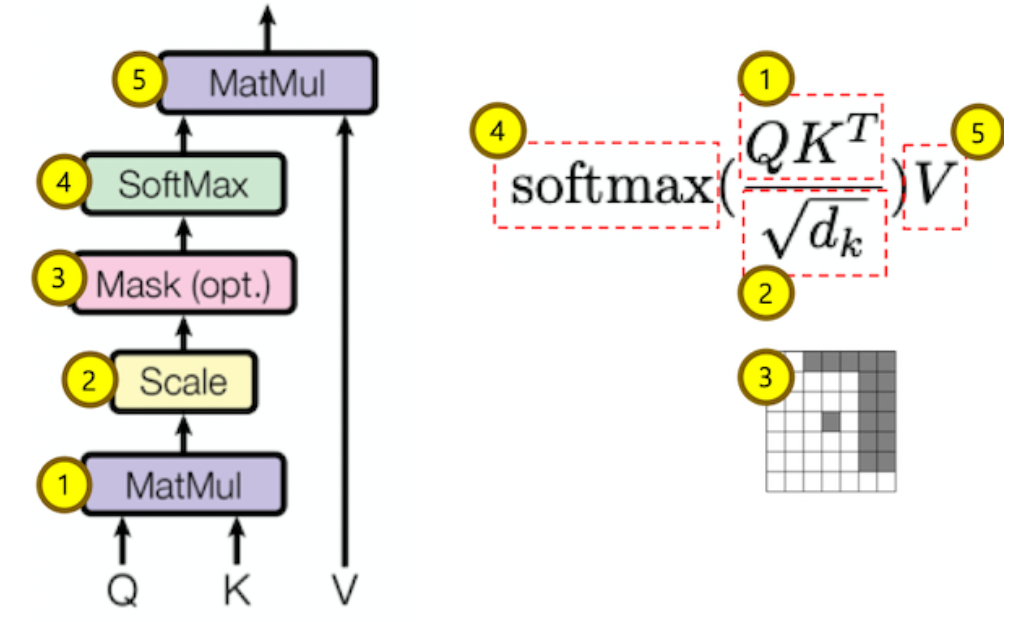

In [37]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
print(attn_mask.size())
print(attn_mask[0]) #only pad(0) parts are True

torch.Size([2, 8, 8])
tensor([[False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False,  True,  True]])


In [39]:
#1. Calculate QK^T
scores = torch.matmul(Q, K.transpose(-1, -2))

#2. Scale
d_head = 64
scores = scores.mul_(1/d_head**0.5)

#3. Mask
scores.masked_fill_(attn_mask, -1e9) #use -1e9 same meaning as -inf

#4. Softmax
attn_prob = nn.Softmax(dim=-1)(scores)

#5. Calculate Softmax(Scaled(QK^T))V 
context = torch.matmul(attn_prob, V)
print(context.size())

torch.Size([2, 8, 128])


Let make this process to class that inherits nn.Module.

In [40]:
""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_head):
        super().__init__()
        self.scale = 1 / (d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2)).mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob

## Step 2-3 : Multi-Head Attention
Inputs : Q, K, V, attn_mask same as ScaledDot.  
2 heads and dimension of head is 64.
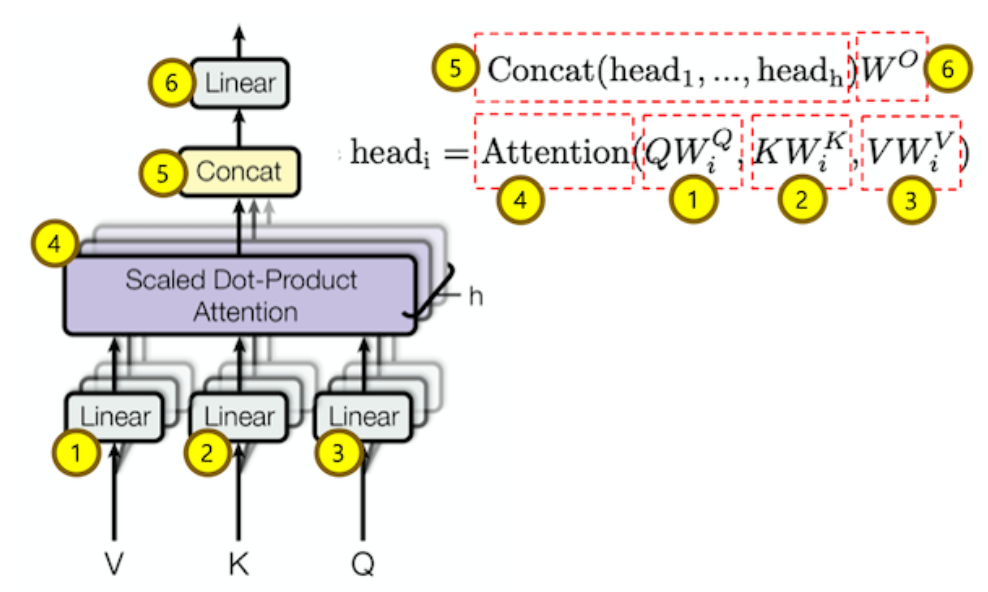

In [41]:
Q = input_sums
K = input_sums
V = input_sums
attn_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_mask = attn_mask.unsqueeze(1).repeat(1, n_head, 1, 1) #convert to multi-head mask

batch_size = Q.size(0)
n_head = 2

In [43]:
#1,2,3. divide Q,K,V by head
W_Q = nn.Linear(d_hidn, n_head * d_head)
W_K = nn.Linear(d_hidn, n_head * d_head)
W_V = nn.Linear(d_hidn, n_head * d_head)

# (bs, n_head, n_seq, d_head)
q_s = W_Q(Q).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
k_s = W_K(K).view(batch_size, -1, n_head, d_head).transpose(1,2)
# (bs, n_head, n_seq, d_head)
v_s = W_V(V).view(batch_size, -1, n_head, d_head).transpose(1,2)

#4. Attention
scaled_dot_attn = ScaledDotProductAttention(d_head)
context, attn_prob = scaled_dot_attn(q_s, k_s, v_s, attn_mask)

#5. Concat Multi Head
# (bs, n_seq, n_head * d_head)
context = context.transpose(1, 2).contiguous().view(batch_size, -1, n_head * d_head)

#6. Linear
linear = nn.Linear(n_head * d_head, d_hidn)
# (bs, n_seq, d_hidn)
output = linear(context)

print(output.size())

torch.Size([2, 8, 128])


Also, make this process to new class.

In [44]:
""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, d_hidn, n_head, d_head):
        super().__init__()
        self.d_hidn = d_hidn
        self.n_head = n_head
        self.d_head = d_head

        self.W_Q = nn.Linear(d_hidn, n_head * d_head)
        self.W_K = nn.Linear(d_hidn, n_head * d_head)
        self.W_V = nn.Linear(d_hidn, n_head * d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(d_head)
        self.linear = nn.Linear(n_head * d_head, d_hidn)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.n_head * self.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

## Step 2-4 : Masked Multi-Head Attention
Same with Multi-Head Attention but add attention mask for decoder.

In [53]:
""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask

""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


Q = input_sums
K = input_sums
V = input_sums

attn_pad_mask = inputs.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), K.size(1))
attn_dec_mask = get_attn_decoder_mask(inputs)
print(attn_dec_mask[1])
attn_mask = torch.gt((attn_pad_mask + attn_dec_mask), 0)
print(attn_mask[1])

batch_size = Q.size(0)
n_head = 2

tensor([[0, 1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[False,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False]])


In [46]:
attention = MultiHeadAttention(d_hidn, n_head, d_head)
output, attn_prob = attention(Q, K, V, attn_mask)
print(output.size(), attn_prob.size())

torch.Size([2, 8, 128]) torch.Size([2, 2, 8, 8])


## Step 2-5 : FeedForward
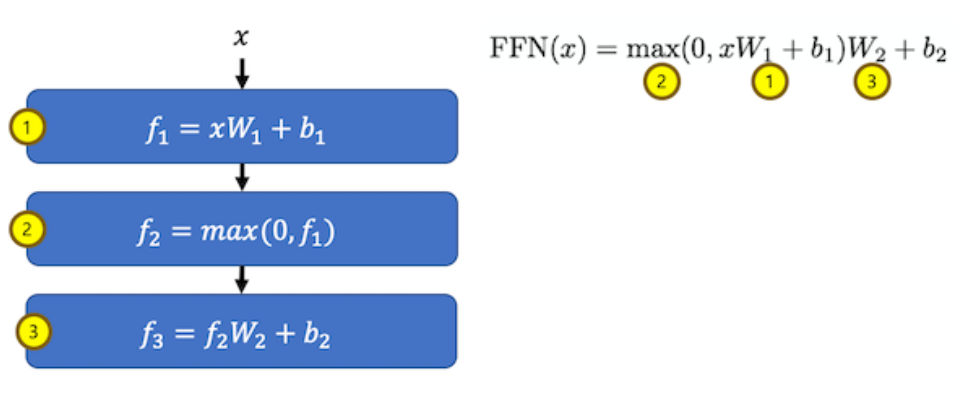

In [48]:
#1. Linear f1
conv1 = nn.Conv1d(in_channels=d_hidn, out_channels=d_hidn * 4, kernel_size=1)
# (bs, d_hidn * 4, n_seq)
ff_1 = conv1(output.transpose(1, 2))
print("f1 size :",ff_1.size())

#2. Activation f2 using GELU
active = F.gelu
ff_2 = active(ff_1)

#3. 
conv2 = nn.Conv1d(in_channels=d_hidn * 4, out_channels=d_hidn, kernel_size=1)
ff_3 = conv2(ff_2).transpose(1, 2)
print("f3 size :",ff_3.size())

f1 size : torch.Size([2, 512, 8])
f3 size : torch.Size([2, 8, 128])


In [49]:
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_hidn):
        super().__init__()

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_hidn * 4, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_hidn * 4, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.active(self.conv1(inputs.transpose(1, 2)))
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        # (bs, n_seq, d_hidn)
        return output

### Step 2 Summary
We prepared every modules which are used to implement Transformer.  
Embedding, Scaled Dot, Multihead, Mask, and FF.  

# Step 3 - Build a Transformer

## Step 3-1 : Config

In [50]:
""" configuration json을 읽어들이는 class """
class Config(dict): 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

Default setting of parameters are a bit small to make it available also at small resource environment.  

In [52]:
config = Config({
    "n_enc_vocab": len(vocab),
    "n_dec_vocab": len(vocab),
    "n_enc_seq": 256,
    "n_dec_seq": 256,
    "n_layer": 6,
    "d_hidn": 256,
    "i_pad": 0,
    "d_ff": 1024,
    "n_head": 4,
    "d_head": 64,
    "dropout": 0.1,
    "layer_norm_epsilon": 1e-12
})

## Step 3-2 : Redefine Classes using config

In [54]:
""" sinusoid position encoding """
def get_sinusoid_encoding_table(n_seq, d_hidn):
    def cal_angle(position, i_hidn):
        return position / np.power(10000, 2 * (i_hidn // 2) / d_hidn)
    def get_posi_angle_vec(position):
        return [cal_angle(position, i_hidn) for i_hidn in range(d_hidn)]

    sinusoid_table = np.array([get_posi_angle_vec(i_seq) for i_seq in range(n_seq)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # even index sin 
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # odd index cos

    return sinusoid_table


""" attention pad mask """
def get_attn_pad_mask(seq_q, seq_k, i_pad):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(i_pad)
    pad_attn_mask= pad_attn_mask.unsqueeze(1).expand(batch_size, len_q, len_k)
    return pad_attn_mask


""" attention decoder mask """
def get_attn_decoder_mask(seq):
    subsequent_mask = torch.ones_like(seq).unsqueeze(-1).expand(seq.size(0), seq.size(1), seq.size(1))
    subsequent_mask = subsequent_mask.triu(diagonal=1) # upper triangular part of a matrix(2-D)
    return subsequent_mask


""" scale dot product attention """
class ScaledDotProductAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.dropout = nn.Dropout(config.dropout)
        self.scale = 1 / (self.config.d_head ** 0.5)
    
    def forward(self, Q, K, V, attn_mask):
        # (bs, n_head, n_q_seq, n_k_seq)
        scores = torch.matmul(Q, K.transpose(-1, -2))
        scores = scores.mul_(self.scale)
        scores.masked_fill_(attn_mask, -1e9)
        # (bs, n_head, n_q_seq, n_k_seq)
        attn_prob = nn.Softmax(dim=-1)(scores)
        attn_prob = self.dropout(attn_prob)
        # (bs, n_head, n_q_seq, d_v)
        context = torch.matmul(attn_prob, V)
        # (bs, n_head, n_q_seq, d_v), (bs, n_head, n_q_seq, n_v_seq)
        return context, attn_prob


""" multi head attention """
class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.W_Q = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_K = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.W_V = nn.Linear(self.config.d_hidn, self.config.n_head * self.config.d_head)
        self.scaled_dot_attn = ScaledDotProductAttention(self.config)
        self.linear = nn.Linear(self.config.n_head * self.config.d_head, self.config.d_hidn)
        self.dropout = nn.Dropout(config.dropout)
    
    def forward(self, Q, K, V, attn_mask):
        batch_size = Q.size(0)
        # (bs, n_head, n_q_seq, d_head)
        q_s = self.W_Q(Q).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_k_seq, d_head)
        k_s = self.W_K(K).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)
        # (bs, n_head, n_v_seq, d_head)
        v_s = self.W_V(V).view(batch_size, -1, self.config.n_head, self.config.d_head).transpose(1,2)

        # (bs, n_head, n_q_seq, n_k_seq)
        attn_mask = attn_mask.unsqueeze(1).repeat(1, self.config.n_head, 1, 1)

        # (bs, n_head, n_q_seq, d_head), (bs, n_head, n_q_seq, n_k_seq)
        context, attn_prob = self.scaled_dot_attn(q_s, k_s, v_s, attn_mask)
        # (bs, n_head, n_q_seq, h_head * d_head)
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.config.n_head * self.config.d_head)
        # (bs, n_head, n_q_seq, e_embd)
        output = self.linear(context)
        output = self.dropout(output)
        # (bs, n_q_seq, d_hidn), (bs, n_head, n_q_seq, n_k_seq)
        return output, attn_prob

    
""" feed forward """
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.conv1 = nn.Conv1d(in_channels=self.config.d_hidn, out_channels=self.config.d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=self.config.d_ff, out_channels=self.config.d_hidn, kernel_size=1)
        self.active = F.gelu
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, inputs):
        # (bs, d_ff, n_seq)
        output = self.conv1(inputs.transpose(1, 2))
        output = self.active(output)
        # (bs, n_seq, d_hidn)
        output = self.conv2(output).transpose(1, 2)
        output = self.dropout(output)
        # (bs, n_seq, d_hidn)
        return output

## Step 3-3 : Encoder
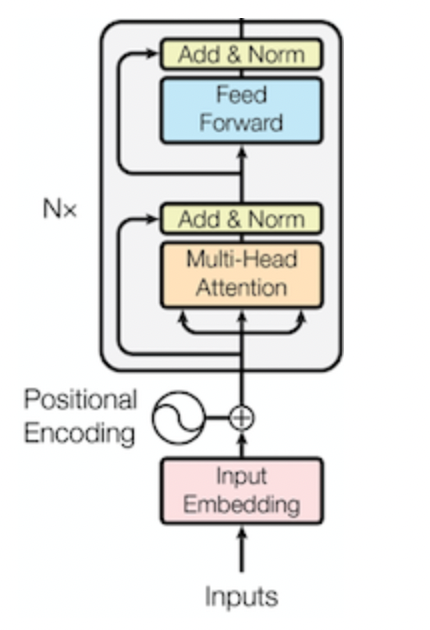  

### Encoder layer
Make a `EncoderLayer` to process inputs by loop.
- 1. Apply Multi-Head Self Attention.
- 2. Add result of 1 and input(residual), then apply LayerNorm.  
- 3. Process FeedForward using result of 2.
- 4. Add result of 2 and 3, then apply LayerNorm.

In [56]:
""" encoder layer """
class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, inputs, attn_mask):
        # 1. Multi-Head Self Attention
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        att_outputs, attn_prob = self.self_attn(inputs, inputs, inputs, attn_mask)
        
        # 2. Add result and residual, apply LayerNorm
        att_outputs = self.layer_norm1(inputs + att_outputs)
        
        # 3. FeedForward
        # (bs, n_enc_seq, d_hidn)
        ffn_outputs = self.pos_ffn(att_outputs)
        
        # 4. Add results, apply LayerNorm
        ffn_outputs = self.layer_norm2(ffn_outputs + att_outputs)
        # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
        return ffn_outputs, attn_prob

### Encoder
- 1. Get position for input.  
- 2. Get Input Embedding and Position Embedding and add them.
- 3. Get attention pad mask for input.
- 4. Go through to `EncoderLayer`.

In [57]:
""" encoder """
class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.enc_emb = nn.Embedding(self.config.n_enc_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_enc_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([EncoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, inputs):
        # 1. Get position
        positions = torch.arange(inputs.size(1), device=inputs.device, dtype=inputs.dtype).expand(inputs.size(0), inputs.size(1)).contiguous() + 1
        pos_mask = inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
        
        # 2. Add Input Embed and Position Embed
        # (bs, n_enc_seq, d_hidn)
        outputs = self.enc_emb(inputs) + self.pos_emb(positions)
        
        # 3. Get attention pad mask
        # (bs, n_enc_seq, n_enc_seq)
        attn_mask = get_attn_pad_mask(inputs, inputs, self.config.i_pad)
        
        # 4. Go through Layers
        attn_probs = []
        for layer in self.layers:
            # (bs, n_enc_seq, d_hidn), (bs, n_head, n_enc_seq, n_enc_seq)
            outputs, attn_prob = layer(outputs, attn_mask)
            attn_probs.append(attn_prob)
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        return outputs, attn_probs

## Step 3-4 : Decoder
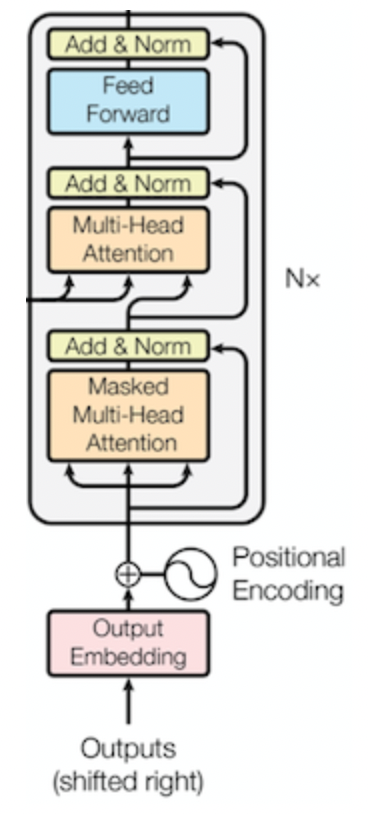  

### Decoder layer
- 1. Multi-Head Self Attention, LayerNorm
- 2. Encoder-Decoder Multi-Head Attention, LayerNorm
- 3. Feed Forward, LayerNorm

In [58]:
""" decoder layer """
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.self_attn = MultiHeadAttention(self.config)
        self.layer_norm1 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.dec_enc_attn = MultiHeadAttention(self.config)
        self.layer_norm2 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
        self.pos_ffn = PoswiseFeedForwardNet(self.config)
        self.layer_norm3 = nn.LayerNorm(self.config.d_hidn, eps=self.config.layer_norm_epsilon)
    
    def forward(self, dec_inputs, enc_outputs, self_attn_mask, dec_enc_attn_mask):
        # 1. Multi-Head Self Attention, LayerNorm
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq)
        self_att_outputs, self_attn_prob = self.self_attn(dec_inputs, dec_inputs, dec_inputs, self_attn_mask)
        self_att_outputs = self.layer_norm1(dec_inputs + self_att_outputs)
        
        # 2. Encoder-Decoder Multi-Head Attention, LayerNorm
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_enc_seq)
        dec_enc_att_outputs, dec_enc_attn_prob = self.dec_enc_attn(self_att_outputs, enc_outputs, enc_outputs, dec_enc_attn_mask)
        dec_enc_att_outputs = self.layer_norm2(self_att_outputs + dec_enc_att_outputs)
        
        # 3. Feed Forward, LayerNorm
        # (bs, n_dec_seq, d_hidn)
        ffn_outputs = self.pos_ffn(dec_enc_att_outputs)
        ffn_outputs = self.layer_norm3(dec_enc_att_outputs + ffn_outputs)
        # (bs, n_dec_seq, d_hidn), (bs, n_head, n_dec_seq, n_dec_seq), (bs, n_head, n_dec_seq, n_enc_seq)
        return ffn_outputs, self_attn_prob, dec_enc_attn_prob

### Decoder
- 1. Input & Position Embedding
- 2. Attention pad mask & Decoder attention mask
- 3. Decoder layers

In [59]:
""" decoder """
class Decoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.dec_emb = nn.Embedding(self.config.n_dec_vocab, self.config.d_hidn)
        sinusoid_table = torch.FloatTensor(get_sinusoid_encoding_table(self.config.n_dec_seq + 1, self.config.d_hidn))
        self.pos_emb = nn.Embedding.from_pretrained(sinusoid_table, freeze=True)

        self.layers = nn.ModuleList([DecoderLayer(self.config) for _ in range(self.config.n_layer)])
    
    def forward(self, dec_inputs, enc_inputs, enc_outputs):
        # 1. Input & Position Embedding
        positions = torch.arange(dec_inputs.size(1), device=dec_inputs.device, dtype=dec_inputs.dtype).expand(dec_inputs.size(0), dec_inputs.size(1)).contiguous() + 1
        pos_mask = dec_inputs.eq(self.config.i_pad)
        positions.masked_fill_(pos_mask, 0)
        # (bs, n_dec_seq, d_hidn)
        dec_outputs = self.dec_emb(dec_inputs) + self.pos_emb(positions)

        # 2. Attention pad mask & Decoder attention mask
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_pad_mask = get_attn_pad_mask(dec_inputs, dec_inputs, self.config.i_pad)
        # (bs, n_dec_seq, n_dec_seq)
        dec_attn_decoder_mask = get_attn_decoder_mask(dec_inputs)
        # (bs, n_dec_seq, n_dec_seq)
        dec_self_attn_mask = torch.gt((dec_attn_pad_mask + dec_attn_decoder_mask), 0)
        # (bs, n_dec_seq, n_enc_seq)
        dec_enc_attn_mask = get_attn_pad_mask(dec_inputs, enc_inputs, self.config.i_pad)

        # 3. Decoder layers
        self_attn_probs, dec_enc_attn_probs = [], []
        for layer in self.layers:
            # (bs, n_dec_seq, d_hidn), (bs, n_dec_seq, n_dec_seq), (bs, n_dec_seq, n_enc_seq)
            dec_outputs, self_attn_prob, dec_enc_attn_prob = layer(dec_outputs, enc_outputs, dec_self_attn_mask, dec_enc_attn_mask)
            self_attn_probs.append(self_attn_prob)
            dec_enc_attn_probs.append(dec_enc_attn_prob)
        # (bs, n_dec_seq, d_hidn), [(bs, n_dec_seq, n_dec_seq)], [(bs, n_dec_seq, n_enc_seq)]S
        return dec_outputs, self_attn_probs, dec_enc_attn_probs

## Step 3-5 : Transformer
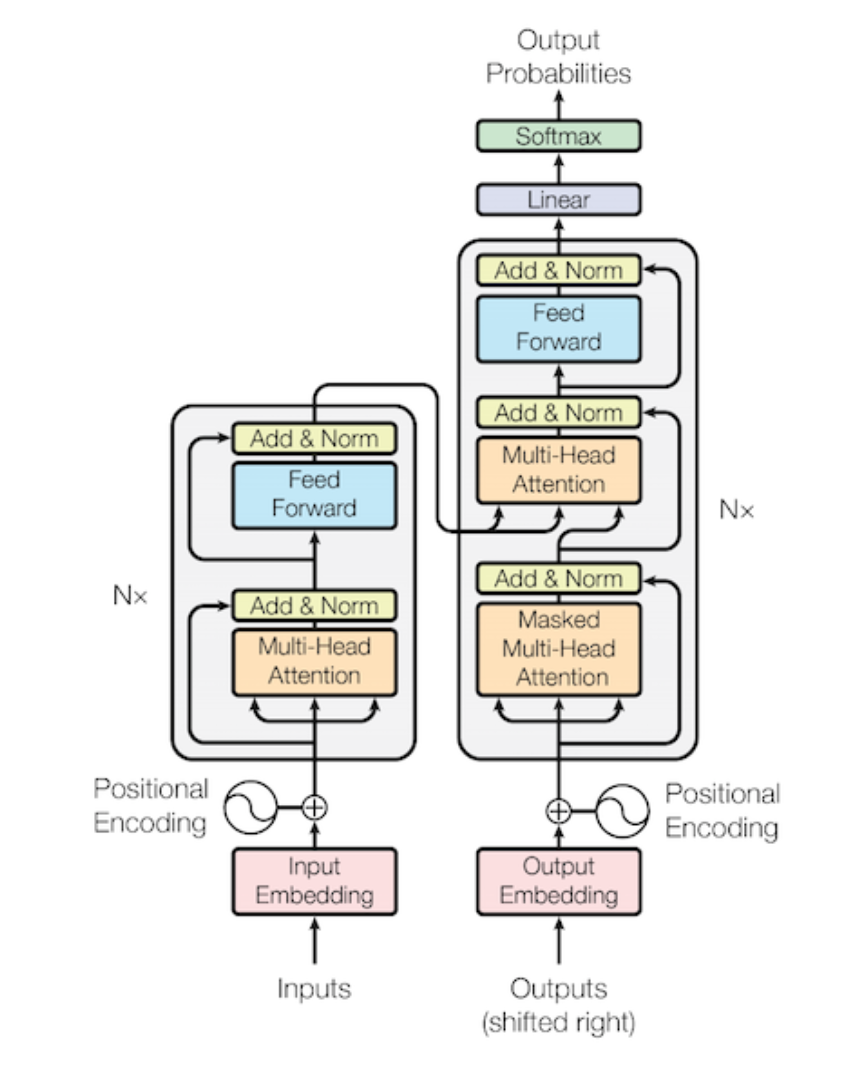
- Put Encoder Input to run Encoder.
- Put Encoder Output and Decoder Input to run Decoder.

In [60]:
""" transformer """
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.encoder = Encoder(self.config)
        self.decoder = Decoder(self.config)
    
    def forward(self, enc_inputs, dec_inputs):
        # (bs, n_enc_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)]
        enc_outputs, enc_self_attn_probs = self.encoder(enc_inputs)
        # (bs, n_seq, d_hidn), [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, dec_self_attn_probs, dec_enc_attn_probs = self.decoder(dec_inputs, enc_inputs, enc_outputs)
        # (bs, n_dec_seq, n_dec_vocab), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

# Step 4 - Apply Transformer (Sentiment Analysis)

## Step 4-1 : Model
- 1. Run Transformer
- 2. Get max value of transformer output
- 3. Apply Linear and make a final prediction

In [67]:
""" naver movie classfication """
class MovieClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = Transformer(self.config)
        self.projection = nn.Linear(self.config.d_hidn, self.config.n_output, bias=False)
    
    def forward(self, enc_inputs, dec_inputs):
        # 1. Transformer
        # (bs, n_dec_seq, d_hidn), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        dec_outputs, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs = self.transformer(enc_inputs, dec_inputs)
        
        # 2. Get max value
        # (bs, d_hidn)
        dec_outputs, _ = torch.max(dec_outputs, dim=1)
        
        # 3. Apply Linear
        # (bs, n_output)
        logits = self.projection(dec_outputs)
        # (bs, n_output), [(bs, n_head, n_enc_seq, n_enc_seq)], [(bs, n_head, n_dec_seq, n_dec_seq)], [(bs, n_head, n_dec_seq, n_enc_seq)]
        return logits, enc_self_attn_probs, dec_self_attn_probs, dec_enc_attn_probs

## Step 4-2 : DataSet
<br/>

### DataSet
- 1. Get 'label' from input file
- 2. Read 'doc' token and convert it to token id(int)
- 3. Decoder input is fixed to '[BOS]'

In [68]:
""" 영화 분류 데이터셋 """
class MovieDataSet(torch.utils.data.Dataset):
    def __init__(self, vocab, infile):
        self.vocab = vocab
        self.labels = []
        self.sentences = []

        line_cnt = 0
        with open(infile, "r") as f:
            for line in f:
                line_cnt += 1

        with open(infile, "r") as f:
            for i, line in enumerate(tqdm(f, total=line_cnt, desc=f"Loading {infile}", unit=" lines")):
                data = json.loads(line)
                #get label and token id
                self.labels.append(data["label"])
                self.sentences.append([vocab.piece_to_id(p) for p in data["doc"]])
    
    def __len__(self):
        assert len(self.labels) == len(self.sentences)
        return len(self.labels)
    
    def __getitem__(self, item):
        return (torch.tensor(self.labels[item]),
                torch.tensor(self.sentences[item]),
                torch.tensor([self.vocab.piece_to_id("[BOS]")]))

### Batch unit processing
- 1. Make encoder inputs' length sames adding padding(0)
- 2. Repeat 1 for decoder inputs
- 3. Label's length is fixed to 1, make it tensor using stack

In [69]:
""" movie data collate_fn """
def movie_collate_fn(inputs):
    labels, enc_inputs, dec_inputs = list(zip(*inputs))

    #padding
    enc_inputs = torch.nn.utils.rnn.pad_sequence(enc_inputs, batch_first=True, padding_value=0)
    dec_inputs = torch.nn.utils.rnn.pad_sequence(dec_inputs, batch_first=True, padding_value=0)
    
    #labels to tensor
    batch = [
        torch.stack(labels, dim=0),
        enc_inputs,
        dec_inputs,
    ]
    return batch

### DataLoader
Make train loader and test loader using above tools.

In [72]:
batch_size = 128
train_dataset = MovieDataSet(vocab, "ratings_train.json")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=movie_collate_fn)
test_dataset = MovieDataSet(vocab, "ratings_test.json")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=movie_collate_fn)

Loading ratings_train.json: 100%|█| 149995/149995 [00:03<00:00, 44425.91 lines/s
Loading ratings_test.json: 100%|███| 49997/49997 [00:01<00:00, 47122.35 lines/s]


## Step 4-3 : Evaluate
Target : `MovieClassification` model  
Evaluation score : Accuracy
- 1. Using Encoder & Decoder inputs, run `MovieClassification`
- 2. First value of 1 is logits
- 3. Get maximum logits' index
- 4. Compare with real labels

In [73]:
""" 모델 epoch 평가 """
def eval_epoch(config, model, data_loader):
    matchs = []
    model.eval()

    n_word_total = 0
    n_correct_total = 0
    with tqdm(total=len(data_loader), desc=f"Valid") as pbar:
        for i, value in enumerate(data_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            # Run model & Predict
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            _, indices = logits.max(1)
            
            # Compare
            match = torch.eq(indices, labels).detach()
            matchs.extend(match.cpu())
            accuracy = np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

            pbar.update(1)
            pbar.set_postfix_str(f"Acc: {accuracy:.3f}")
    return np.sum(matchs) / len(matchs) if 0 < len(matchs) else 0

## Step 4-4 : Train
- 1. Using Encoder & Decoder inputs, run `MovieClassification`
- 2. First value of 1 is logits
- 3. Calculate Loss using logits and labels
- 4. Train with loss, optimizer

In [74]:
""" 모델 epoch 학습 """
def train_epoch(config, epoch, model, criterion, optimizer, train_loader):
    losses = []
    model.train()

    with tqdm(total=len(train_loader), desc=f"Train {epoch}") as pbar:
        for i, value in enumerate(train_loader):
            labels, enc_inputs, dec_inputs = map(lambda v: v.to(config.device), value)

            optimizer.zero_grad()
            # Run MovieClassification
            outputs = model(enc_inputs, dec_inputs)
            logits = outputs[0]
            
            # Calculate Loss
            loss = criterion(logits, labels)
            loss_val = loss.item()
            losses.append(loss_val)
            
            # train with loss
            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss_val:.3f} ({np.mean(losses):.3f})")
    return np.mean(losses)

In [75]:
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.n_output = 2
print(config)

learning_rate = 5e-5
n_epoch = 10

{'n_enc_vocab': 8007, 'n_dec_vocab': 8007, 'n_enc_seq': 256, 'n_dec_seq': 256, 'n_layer': 6, 'd_hidn': 256, 'i_pad': 0, 'd_ff': 1024, 'n_head': 4, 'd_head': 64, 'dropout': 0.1, 'layer_norm_epsilon': 1e-12, 'device': device(type='cpu'), 'n_output': 2}


In [ ]:
model = MovieClassification(config)
model.to(config.device) # choose proper device

criterion = torch.nn.CrossEntropyLoss() # Use CrossEntropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Use Adam

losses, scores = [], []

#train and evaluate for each epoch
for epoch in range(n_epoch):
    loss = train_epoch(config, epoch, model, criterion, optimizer, train_loader)
    score = eval_epoch(config, model, test_loader)

    losses.append(loss)
    scores.append(score)

Train 0:   6%|▌        | 68/1172 [15:55<4:14:29, 13.83s/it, Loss: 0.597 (0.687)]

#  Result

In [ ]:
# table
data = {
    "loss": losses,
    "score": scores
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.plot(scores, label="score")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.show()